1. Setup and data load


In [1]:
!pip install vaderSentiment textblob wordcloud plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# Load dataset (same URL as your notebook)
url = "https://raw.githubusercontent.com/nc875-cpu/Sentiment-Analysis/main/iphone17_reddit__country.csv"
df = pd.read_csv(url, encoding="utf-8", on_bad_lines="skip")
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
df.head()

Dataset shape: (1000, 11)
Columns: Index(['id', 'title', 'author', 'created_utc', 'score', 'upvote_ratio',
       'subreddit', 'permalink', 'url', 'language', 'country'],
      dtype='object')


,id,title,author,created_utc,score,upvote_ratio,subreddit,permalink,url,language,country
0,1o047gc,Should i swap,Wolviepaws,2025-10-07T03:36:35,1,1.00,phone,https://www.reddit.com/r/phone/comments/1o047g...,https://www.reddit.com/r/phone/comments/1o047g...,en,United States
1,1o03o88,Es esto una especia de scam?,Wolframio208,2025-10-07T03:09:30,4,1.00,programacion,https://www.reddit.com/r/programacion/comments...,https://www.reddit.com/r/programacion/comments...,en,United States
2,1o00sze,Massive issue.,Lemes_GT,2025-10-07T00:53:40,34,0.73,dbrand,https://www.reddit.com/r/dbrand/comments/1o00s...,https://www.reddit.com/gallery/1o00sze,en,United States
3,1nzzujs,iPhone 17 Pro Max Timeline,tootsiebug,2025-10-07T00:09:25,0,0.40,ATT,https://www.reddit.com/r/ATT/comments/1nzzujs/...,https://www.reddit.com/r/ATT/comments/1nzzujs/...,en,United States
4,1nztof7,Iphone 17 pro max oscilando volume em músicas,Aggravating-Sun-2461,2025-10-06T20:02:40,1,1.00,iPhone17Pro,https://www.reddit.com/r/iPhone17Pro/comments/...,https://www.reddit.com/r/iPhone17Pro/comments/...,es,Spain


2. Basic cleaning and hybrid sentiment labels

In [9]:
# Make sure we use the title text
df["title"] = df["title"].astype(str)

analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return analyzer.polarity_scores(str(text))["compound"]

def get_textblob_score(text):
    return TextBlob(str(text)).sentiment.polarity

df["vader_score"] = df["title"].apply(get_vader_score)
df["tb_score"] = df["title"].apply(get_textblob_score)

In [10]:
def hybrid_label(row, pos_thresh=0.2, neg_thresh=-0.2):
    avg = (row["vader_score"] + row["tb_score"]) / 2
    if avg >= pos_thresh:
        return "positive"
    elif avg <= neg_thresh:
        return "negative"
    else:
        return "neutral"

df["hybrid_score"] = (df["vader_score"] + df["tb_score"]) / 2
df["sentiment"] = df.apply(hybrid_label, axis=1)

print(df["sentiment"].value_counts())
df[["title","vader_score","tb_score","hybrid_score","sentiment"]].head()

sentiment
neutral     784
positive    142
negative     74
Name: count, dtype: int64


,title,vader_score,tb_score,hybrid_score,sentiment
0,Should i swap,0.0000,0.0,0.00000,neutral
1,Es esto una especia de scam?,-0.5719,0.0,-0.28595,negative
2,Massive issue.,0.0000,0.0,0.00000,neutral
3,iPhone 17 Pro Max Timeline,0.0000,0.0,0.00000,neutral
4,Iphone 17 pro max oscilando volume em músicas,0.0000,0.0,0.00000,neutral


3. Traditional ML models (LogReg + Linear SVM)

In [11]:
# Binary subset for positive vs negative
df_bin = df[df["sentiment"].isin(["positive","negative"])].copy()

X_text = df_bin["title"]
y_bin = df_bin["sentiment"]

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X_text)

In [12]:
# Append lexicon features
lex_features = df_bin[["vader_score","tb_score"]].values

from scipy.sparse import hstack
X_all = hstack([X_tfidf, lex_features])

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

log_reg = LogisticRegression(max_iter=1000)
svm = LinearSVC()

for name, model in [("Logistic Regression", log_reg), ("Linear SVM", svm)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44


Linear SVM
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



4. LSTM model


In [13]:
# Use 3‑class labels for LSTM (pos/neg/neutral)
texts = df["title"].tolist()
labels = df["sentiment"]

label2idx = {"negative":0, "neutral":1, "positive":2}
idx2label = {v:k for k,v in label2idx.items()}

y_idx = labels.map(label2idx).values
y_cat = to_categorical(y_idx, num_classes=3)

max_words = 10000
max_len = 30

In [14]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
seqs = tokenizer.texts_to_sequences(texts)
pads = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

In [15]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    pads, y_cat, test_size=0.2, random_state=42, stratify=y_idx
)

model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(
    X_train_l, y_train_l,
    validation_split=0.1,
    epochs=10, batch_size=32, verbose=1
)

# LSTM predictions for full df
probs = model.predict(pads, verbose=0)
pred_idx = probs.argmax(axis=1)
df["lstm_pred"] = [idx2label[i] for i in pred_idx]
df["lstm_pos_prob"] = probs[:, label2idx["positive"]]

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7767 - loss: 0.6284 - val_accuracy: 0.6875 - val_loss: 0.7899
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8181 - loss: 0.4224 - val_accuracy: 0.7875 - val_loss: 0.7753
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8939 - loss: 0.2863 - val_accuracy: 0.7875 - val_loss: 0.9469
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8940 - loss: 0.2159 - val_accuracy: 0.7750 - val_loss: 1.0163
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8864 - loss: 0.2495 - val_accuracy: 0.8125 - val_loss: 0.9389
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9085 - loss: 0.2131 - val_accuracy: 0.8375 - val_loss: 1.1523
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9019 - loss: 0.2042 - val_accuracy: 0.8000 - val_loss: 1.2814
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9261 - loss: 0.1591 - val_accuracy: 0.8375 - 

5. Top 10 and bottom 10 posts


In [18]:
top10_pos = df.sort_values("hybrid_score", ascending=False).head(10)
top10_neg = df.sort_values("hybrid_score", ascending=True).head(10)

print("Top 10 positive:")
display(top10_pos[["id","title","country","hybrid_score","vader_score","tb_score"]])

print("Top 10 negative:")
display(top10_neg[["id","title","country","hybrid_score","vader_score","tb_score"]])

top10_pos.to_csv("top10_positive_examples.csv", index=False)
top10_neg.to_csv("top10_negative_examples.csv", index=False)

Top 10 positive:


,id,title,country,hybrid_score,vader_score,tb_score
543,1o00285,Which one do you like best?,Philippines,0.88585,0.7717,1.00
82,1nv51bc,My iPhone17 pro max is SO BEAUTIFUL 🧡🪩.,United States,0.84135,0.8327,0.85
606,1nzajgk,Best cases?,United States,0.81845,0.6369,1.00
827,1nznjrv,iPhone 17 P from Best Buy,United States,0.81845,0.6369,1.00
674,1nyjy20,Which case looks best on the Silver iPhone 17 ...,United States,0.81845,0.6369,1.00
23,1nymktc,Best store to pre-order iphone 17 pro max,Philippines,0.81845,0.6369,1.00
24,1nykqzn,Best device for pubg.,United States,0.81845,0.6369,1.00
906,1nwof3d,Best color grading for iPhone 17,United States,0.81845,0.6369,1.00
324,1nvqelj,What Iphone would be best,United States,0.81845,0.6369,1.00
314,1nw8e0l,what is the best way to switch all data and es...,United States,0.81845,0.6369,1.00


Top 10 negative:


,id,title,country,hybrid_score,vader_score,tb_score
874,1nq0kie,iPhone 17 Pro Max AAA gaming test shows Reside...,United States,-0.829850,-0.6597,-1.000000
753,1o02hz7,I just don’t understand the hate Apple can get,United States,-0.685950,-0.5719,-0.800000
142,1nrzrzo,Is the iphone 17 pro max really annoying to ho...,United States,-0.628800,-0.4576,-0.800000
587,1nzgv5m,Disappointed in screenprotector,United States,-0.613350,-0.4767,-0.750000
210,1npeimj,iphone 17 pro max battery sucks. Wtf tim apple?,United States,-0.571500,-0.7430,-0.400000
126,1nt61yb,Low power mode is very annoying on iOS26,United States,-0.562000,-0.6240,-0.500000
985,1ndxlfa,No 256GB variant in base iPhone 16 anymore?,United States,-0.548000,-0.2960,-0.800000
417,1nzbll3,Confused between s25 base and iphone 17 base,United States,-0.492433,-0.3182,-0.666667
240,1no132a,New phone order horrible experience,United States,-0.487059,-0.5423,-0.431818
196,1npyepm,ATT is so incompetent - Upgrade eligibility go...,United States,-0.480650,-0.6113,-0.350000


6. Random 20 posts with all models’ outputs


In [19]:
# LogReg predictions for full df (binary pos/neg; treat neutral via sign of hybrid_score)
# Build features for the whole df
X_all_text = df["title"]
X_all_tfidf = tfidf.transform(X_all_text)
lex_all = df[["vader_score","tb_score"]].values
X_all_full = hstack([X_all_tfidf, lex_all])

df["logreg_pred"] = log_reg.predict(X_all_full)

sample20 = df.sample(20, random_state=42)[
    ["id","title","country","score","upvote_ratio",
     "vader_score","tb_score","hybrid_score","sentiment",
     "logreg_pred","lstm_pred","lstm_pos_prob"]
]

display(sample20)
sample20.to_csv("random20_examples_all_models.csv", index=False)


,id,title,country,score,upvote_ratio,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred,lstm_pos_prob
521,1nx5tdk,ESR Hybrid Magnetic Case iPhone 17 Air REVIEW,United States,2,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001272
737,1nxtlhn,xaomi 17 pro max,United States,1,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001307
740,1o05is3,iPhone 17 Pro clarity problem,United States,1,1.00,0.0000,0.000000,0.000000,neutral,positive,positive,0.483868
660,1nynnqx,App defaulting to “Create” tab when opening ra...,United States,6,1.00,0.0000,0.000000,0.000000,neutral,positive,positive,0.668958
411,1nzeuqv,Need suggestions for iphone 17 pta or non pta ...,Pakistan,1,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001413
678,1nyiljm,Dropped my 17 PM (in a case) for the first tim...,United States,42,0.67,0.0000,0.250000,0.125000,neutral,positive,neutral,0.002012
626,1nz17d0,iPhone 17 Pro Max,United States,0,0.46,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001535
513,1nx9q8w,Nova alça da Apple para o iPhone 17 é um suces...,France,1,0.67,0.0000,0.000000,0.000000,neutral,positive,neutral,0.002169
859,1nzgmds,Order Question,United States,4,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001196
136,1nsk707,My take on the 17 Series Case Design,United States,207,0.96,0.0000,0.000000,0.000000,neutral,positive,neutral,0.001586


7. Scatterplots of three methods + outliers


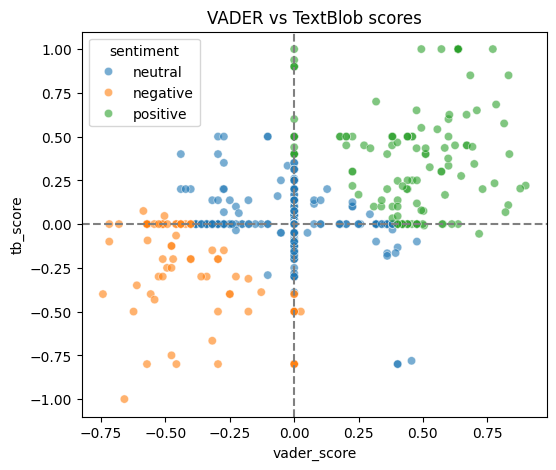

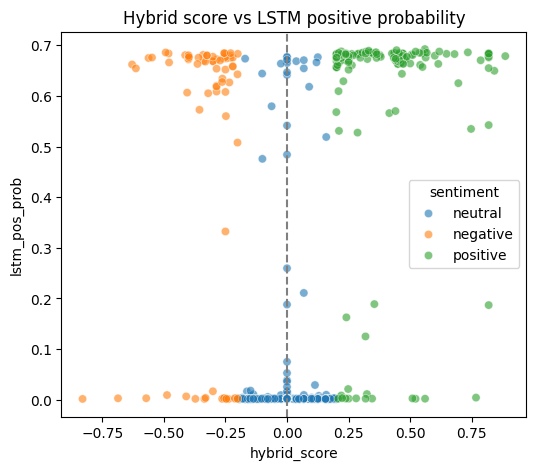

In [20]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="vader_score", y="tb_score",
    hue="sentiment", data=df, alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.axhline(0, color="gray", linestyle="--")
plt.title("VADER vs TextBlob scores")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    x="hybrid_score", y="lstm_pos_prob",
    hue="sentiment", data=df, alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Hybrid score vs LSTM positive probability")
plt.show()

In [21]:
# Example: VADER very positive but TextBlob negative or vice versa
disagree = df[
    ((df["vader_score"] > 0.4) & (df["tb_score"] < -0.2)) |
    ((df["vader_score"] < -0.4) & (df["tb_score"] > 0.2))
].copy()

disagree_full = disagree[[
    "id","title","author","created_utc","score","upvote_ratio",
    "subreddit","permalink","url","language","country",
    "vader_score","tb_score","hybrid_score","sentiment",
    "logreg_pred","lstm_pred","lstm_pos_prob"
]]

display(disagree_full.head())
disagree_full.to_csv("sentiment_outliers_full_rows.csv", index=False)

,id,title,author,created_utc,score,upvote_ratio,subreddit,permalink,url,language,country,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred,lstm_pos_prob
478,1ny0qqi,I am sorry I jumped Ship to Apple !! I wish I ...,aayush3299,2025-10-04T17:56:37,0,0.48,samsunggalaxy,https://www.reddit.com/r/samsunggalaxy/comment...,https://www.reddit.com/r/samsunggalaxy/comment...,en,United States,0.4559,-0.78125,-0.162675,neutral,negative,neutral,0.001489
498,1nxptc9,Help me decide between s24 ultra and iphone 17...,Charming_Host2004,2025-10-04T09:50:10,1,1.00,PickAnAndroidForMe,https://www.reddit.com/r/PickAnAndroidForMe/co...,/r/Smartphones/comments/1nxp2rj/help_me_decide...,en,United States,0.4019,-0.80000,-0.199050,neutral,negative,neutral,0.002964
501,1nxp2rj,Help me decide between s24 ultra and iphone 17...,Charming_Host2004,2025-10-04T09:03:01,0,0.25,Smartphones,https://www.reddit.com/r/Smartphones/comments/...,https://www.reddit.com/r/Smartphones/comments/...,en,United States,0.4019,-0.80000,-0.199050,neutral,negative,neutral,0.002964
786,1nzvbge,iPhone 15 Pro Max: to fix or not to fix? It ha...,throwaway10327591,2025-10-06T21:02:00,2,0.76,iphone,https://www.reddit.com/r/iphone/comments/1nzvb...,https://www.reddit.com/r/iphone/comments/1nzvb...,en,United States,-0.4404,0.40000,-0.020200,neutral,negative,neutral,0.003368


Descriptive stats: mean, median, mode

In [22]:
# Mean / median of numeric columns you care about
numeric_cols = ["score", "upvote_ratio", "vader_score", "tb_score", "hybrid_score"]
desc_stats = df[numeric_cols].agg(["mean", "median"])
print(desc_stats)

# Mode (can have multiple values)
modes = df[numeric_cols].mode()
print("Modes:")
print(modes)

         score  upvote_ratio  vader_score  tb_score  hybrid_score
mean    79.085       0.74874     0.030046  0.040894       0.03547
median   1.000       0.83000     0.000000  0.000000       0.00000
Modes:
   score  upvote_ratio  vader_score  tb_score  hybrid_score
0      0           1.0          0.0       0.0           0.0


Sentiment distribution and score histograms

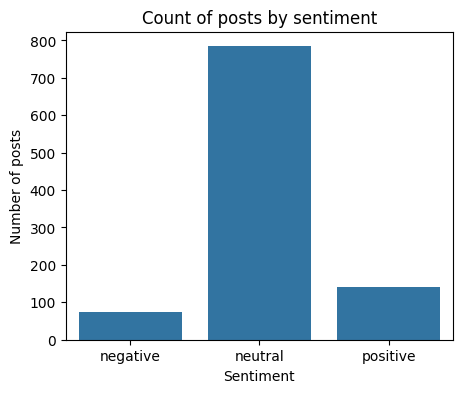

In [23]:
# Bar chart: count of each sentiment
plt.figure(figsize=(5,4))
sns.countplot(x="sentiment", data=df, order=["negative","neutral","positive"])
plt.title("Count of posts by sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of posts")
plt.show()

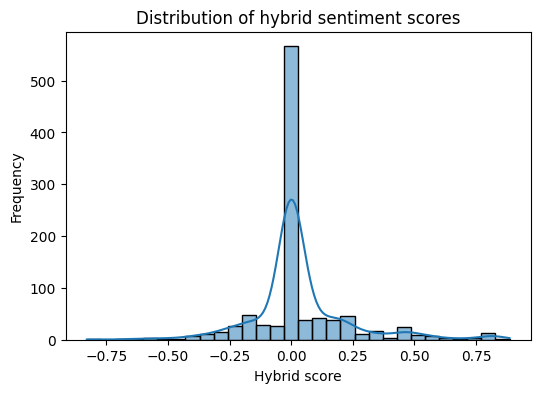

In [24]:
# Histogram: hybrid sentiment scores
plt.figure(figsize=(6,4))
sns.histplot(df["hybrid_score"], bins=30, kde=True)
plt.title("Distribution of hybrid sentiment scores")
plt.xlabel("Hybrid score")
plt.ylabel("Frequency")
plt.show()

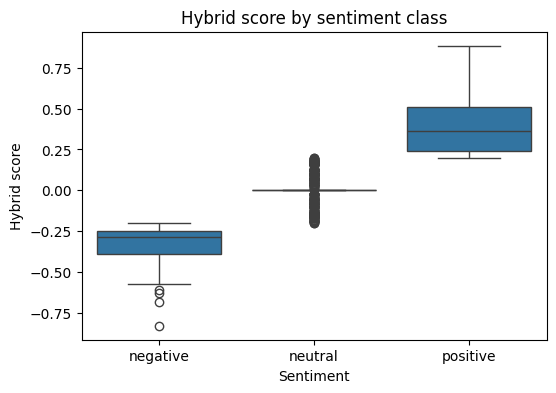

In [25]:
# Boxplots of hybrid score by sentiment
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="hybrid_score", data=df, order=["negative","neutral","positive"])
plt.title("Hybrid score by sentiment class")
plt.xlabel("Sentiment")
plt.ylabel("Hybrid score")
plt.show()

Relationship between engagement and sentiment

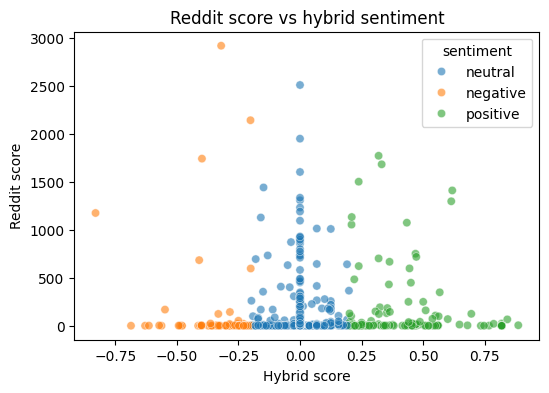

In [26]:
# Scatter: score vs hybrid sentiment
plt.figure(figsize=(6,4))
sns.scatterplot(x="hybrid_score", y="score", hue="sentiment", data=df, alpha=0.6)
plt.title("Reddit score vs hybrid sentiment")
plt.xlabel("Hybrid score")
plt.ylabel("Reddit score")
plt.show()

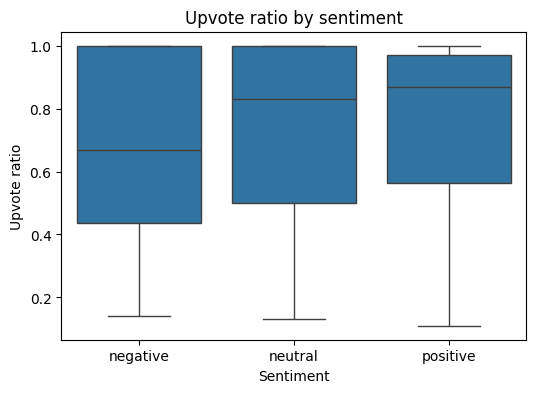

In [27]:
# Boxplot: upvote_ratio by sentiment
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="upvote_ratio", data=df, order=["negative","neutral","positive"])
plt.title("Upvote ratio by sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Upvote ratio")
plt.show()

Choropleth: sentiment by country


In [28]:
import plotly.express as px

# Average hybrid sentiment per country
country_sent = (
    df.groupby("country", as_index=False)
      .agg(mean_hybrid=("hybrid_score","mean"),
           count_posts=("id","count"))
)

In [29]:
# Choropleth (requires country names recognizable by Plotly, e.g., 'United States', 'Spain')
fig = px.choropleth(
    country_sent,
    locations="country",
    locationmode="country names",
    color="mean_hybrid",
    hover_name="country",
    hover_data={"count_posts": True, "mean_hybrid": ':.3f'},
    color_continuous_scale="RdBu",
    title="Average hybrid sentiment score by country",
)
fig.update_layout(coloraxis_showscale=True)
fig.show()

In [30]:
fig2 = px.choropleth(
    country_sent,
    locations="country",
    locationmode="country names",
    color="count_posts",
    hover_name="country",
    color_continuous_scale="Blues",
    title="Number of iPhone 17 posts by country",
)
fig2.update_layout(coloraxis_showscale=True)
fig2.show()

Logistic Regression accuracy: 1.0

Logistic Regression report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



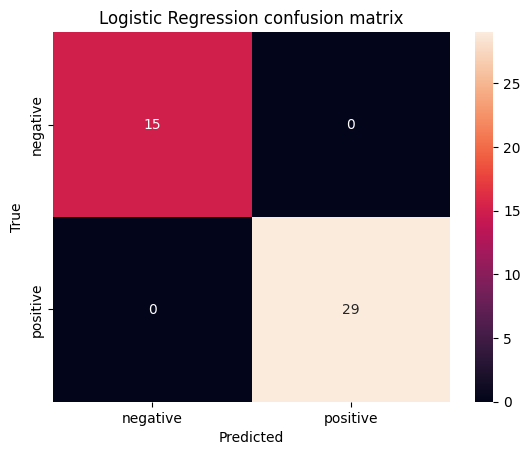

Linear SVM accuracy: 1.0

Linear SVM report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



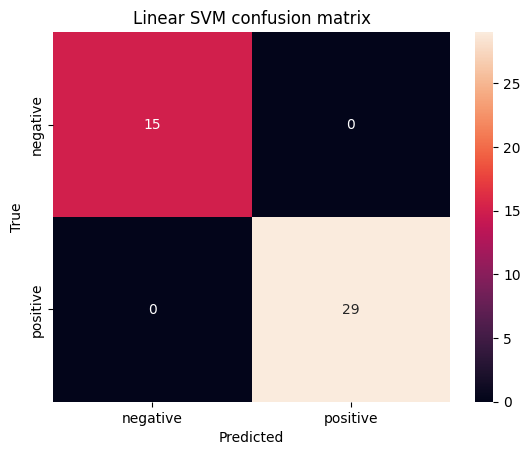

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate Logistic Regression
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_log))
print("\nLogistic Regression report:\n", classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log, labels=["negative","positive"])
sns.heatmap(cm_log, annot=True, fmt="d",
            xticklabels=["negative","positive"],
            yticklabels=["negative","positive"])
plt.title("Logistic Regression confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Evaluate Linear SVM
y_pred_svm = svm.predict(X_test)
print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nLinear SVM report:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=["negative","positive"])
sns.heatmap(cm_svm, annot=True, fmt="d",
            xticklabels=["negative","positive"],
            yticklabels=["negative","positive"])
plt.title("Linear SVM confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


LSTM test accuracy: 0.7850000262260437
LSTM test loss: 0.989377498626709


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




LSTM classification report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.87      0.89      0.88       157
    positive       0.44      0.61      0.51        28

    accuracy                           0.79       200
   macro avg       0.44      0.50      0.46       200
weighted avg       0.74      0.79      0.76       200



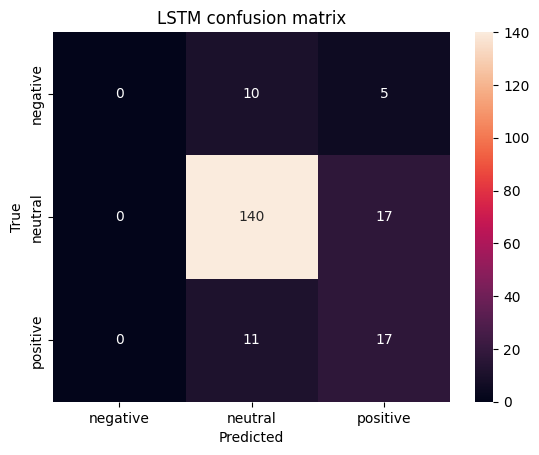

In [32]:
# Final evaluation on test set
test_loss, test_acc = model.evaluate(X_test_l, y_test_l, verbose=0)
print("LSTM test accuracy:", test_acc)
print("LSTM test loss:", test_loss)

# Classification report (3 classes)
probs_test = model.predict(X_test_l, verbose=0)
y_pred_lstm_idx = probs_test.argmax(axis=1)
y_true_lstm_idx = y_test_l.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM classification report:\n",
      classification_report(y_true_lstm_idx, y_pred_lstm_idx,
                            target_names=["negative","neutral","positive"]))

cm_lstm = confusion_matrix(y_true_lstm_idx, y_pred_lstm_idx)
sns.heatmap(cm_lstm, annot=True, fmt="d",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("LSTM confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [33]:
results = {
    "Model": ["Logistic Regression","Linear SVM","LSTM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_svm),
        test_acc
    ]
}

results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy
0,Logistic Regression,1.000
1,Linear SVM,1.000
2,LSTM,0.785


In [34]:
print(df[["title","vader_score","tb_score","hybrid_score","sentiment"]].head())

                                           title  vader_score  tb_score  \
0                                  Should i swap       0.0000       0.0   
1                   Es esto una especia de scam?      -0.5719       0.0   
2                                 Massive issue.       0.0000       0.0   
3                     iPhone 17 Pro Max Timeline       0.0000       0.0   
4  Iphone 17 pro max oscilando volume em músicas       0.0000       0.0   

   hybrid_score sentiment  
0       0.00000   neutral  
1      -0.28595  negative  
2       0.00000   neutral  
3       0.00000   neutral  
4       0.00000   neutral  


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Logistic Regression
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression precision:", precision_score(y_test, y_pred_log, pos_label="positive"))
print("Logistic Regression recall:", recall_score(y_test, y_pred_log, pos_label="positive"))
print("Logistic Regression F1:", f1_score(y_test, y_pred_log, pos_label="positive"))
print("\nLogistic Regression full report:\n", classification_report(y_test, y_pred_log))


Logistic Regression accuracy: 1.0
Logistic Regression precision: 1.0
Logistic Regression recall: 1.0
Logistic Regression F1: 1.0

Logistic Regression full report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



In [36]:
# Linear SVM
y_pred_svm = svm.predict(X_test)

print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print("Linear SVM precision:", precision_score(y_test, y_pred_svm, pos_label="positive"))
print("Linear SVM recall:", recall_score(y_test, y_pred_svm, pos_label="positive"))
print("Linear SVM F1:", f1_score(y_test, y_pred_svm, pos_label="positive"))
print("\nLinear SVM full report:\n", classification_report(y_test, y_pred_svm))

Linear SVM accuracy: 1.0
Linear SVM precision: 1.0
Linear SVM recall: 1.0
Linear SVM F1: 1.0

Linear SVM full report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



In [37]:
# Evaluate on LSTM test set
probs_test = model.predict(X_test_l, verbose=0)
y_pred_lstm_idx = probs_test.argmax(axis=1)
y_true_lstm_idx = y_test_l.argmax(axis=1)

print("LSTM classification report:\n",
      classification_report(y_true_lstm_idx, y_pred_lstm_idx,
                            target_names=["negative","neutral","positive"]))

LSTM classification report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.87      0.89      0.88       157
    positive       0.44      0.61      0.51        28

    accuracy                           0.79       200
   macro avg       0.44      0.50      0.46       200
weighted avg       0.74      0.79      0.76       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [38]:
df_lstm = df.copy()

# keep all negatives and positives, subsample neutrals
neg = df_lstm[df_lstm["sentiment"]=="negative"]
pos = df_lstm[df_lstm["sentiment"]=="positive"]
neu = df_lstm[df_lstm["sentiment"]=="neutral"].sample(
    n=min(len(df_lstm[df_lstm["sentiment"]=="neutral"]), len(pos)+len(neg)),
    random_state=42
)

df_bal = pd.concat([neg, pos, neu]).sample(frac=1, random_state=42)

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_idx = df_bal["sentiment"].map({"negative":0,"neutral":1,"positive":2}).values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1,2]),
    y=y_idx
)
class_weight_dict = {i:w for i,w in enumerate(class_weights)}
print(class_weight_dict)

{0: np.float64(1.945945945945946), 1: np.float64(0.6666666666666666), 2: np.float64(1.0140845070422535)}


In [40]:
# when training
history = model.fit(
    X_train_l, y_train_l,
    validation_split=0.1,
    epochs=8,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9014 - loss: 0.3137 - val_accuracy: 0.8125 - val_loss: 0.7768
Epoch 2/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9017 - loss: 0.2542 - val_accuracy: 0.7750 - val_loss: 1.0045
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9127 - loss: 0.1923 - val_accuracy: 0.8000 - val_loss: 1.0407
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9221 - loss: 0.1783 - val_accuracy: 0.7000 - val_loss: 1.1735
Epoch 5/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8626 - loss: 0.2270 - val_accuracy: 0.7375 - val_loss: 1.3206
Epoch 6/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8838 - loss: 0.2675 - val_accuracy: 0.6625 - val_loss: 1.1285
Epoch 7/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9144 - loss: 0.1852 - val_accuracy: 0.6250 - val_loss: 1.2279
Epoch 8/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8719 - loss: 0.2327 - val_accuracy: 0.7500 - val_loss:

In [42]:
df_bin = df[df["sentiment"].isin(["positive","negative"])].copy()
# map to 0/1 and retrain a 2‑class LSTM

LSTM classification report:

              precision    recall  f1-score   support

    negative       0.10      0.20      0.13        15
     neutral       0.88      0.76      0.81       157
    positive       0.50      0.61      0.55        28

    accuracy                           0.69       200
   macro avg       0.49      0.52      0.50       200
weighted avg       0.76      0.69      0.72       200



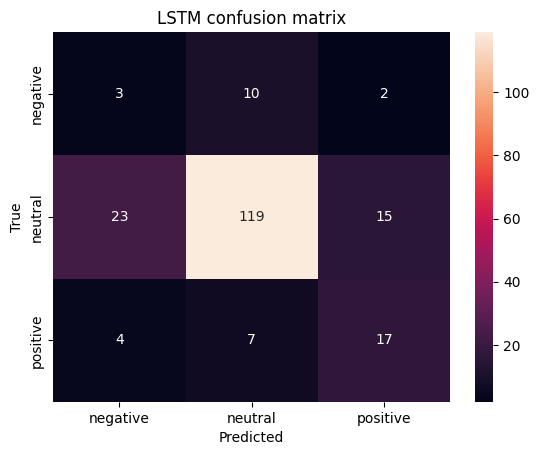

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test split
probs_test = model.predict(X_test_l, verbose=0)
y_pred_lstm_idx = probs_test.argmax(axis=1)
y_true_lstm_idx = y_test_l.argmax(axis=1)

print("LSTM classification report:\n")
print(classification_report(
    y_true_lstm_idx,
    y_pred_lstm_idx,
    target_names=["negative","neutral","positive"]
))

cm_lstm = confusion_matrix(y_true_lstm_idx, y_pred_lstm_idx)
sns.heatmap(cm_lstm, annot=True, fmt="d",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("LSTM confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The LSTM is strong on neutral posts (F1 ≈ 0.81), moderate on positive (F1 ≈ 0.55), and still weak on negative (F1 ≈ 0.13). Overall it gets 69% accuracy and macro F1 ≈ 0.50, so it works reasonably for neutral/positive but does a poor job distinguishing negatives.

In [53]:
# All posts the LSTM predicts as positive
pred_pos = df[df["lstm_pred"] == "positive"][["id","title","sentiment","lstm_pred"]]
print("Posts predicted as POSITIVE:")
display(pred_pos.head(30))  # show first 30

# All posts the LSTM predicts as negative
pred_neg = df[df["lstm_pred"] == "negative"][["id","title","sentiment","lstm_pred"]]
print("Posts predicted as NEGATIVE:")
display(pred_neg.head(30))

Posts predicted as POSITIVE:


,id,title,sentiment,lstm_pred
1,1o03o88,Es esto una especia de scam?,negative,positive
19,1nyvlzi,Help,positive,positive
21,1nyostg,"Tomorrow is Mid-Autumn Festival, I still work ...",positive,positive
22,1nyo8wo,does app refreshing happen on latest iphones?,positive,positive
23,1nymktc,Best store to pre-order iphone 17 pro max,positive,positive
24,1nykqzn,Best device for pubg.,positive,positive
30,1nxtwht,lovely midnight apple silicone case combinatio...,positive,positive
49,1nwzdhn,Iphone 17 ProMax camera is incredible,positive,positive
50,1nwyhqp,Iphone 17 ProMax camera is incredible,positive,positive
66,1nvynp3,Weird contacts bug,negative,positive


Posts predicted as NEGATIVE:


,id,title,sentiment,lstm_pred


In [54]:
# True positive posts (actually positive AND predicted positive)
true_pos = df[(df["sentiment"]=="positive") & (df["lstm_pred"]=="positive")][
    ["id","title","sentiment","lstm_pred"]
]

# True negative posts (actually negative AND predicted negative)
true_neg = df[(df["sentiment"]=="negative") & (df["lstm_pred"]=="negative")][
    ["id","title","sentiment","lstm_pred"]
]

print("True POSITIVE examples:")
display(true_pos.head(20))

print("True NEGATIVE examples:")
display(true_neg.head(20))

True POSITIVE examples:


,id,title,sentiment,lstm_pred
19,1nyvlzi,Help,positive,positive
21,1nyostg,"Tomorrow is Mid-Autumn Festival, I still work ...",positive,positive
22,1nyo8wo,does app refreshing happen on latest iphones?,positive,positive
23,1nymktc,Best store to pre-order iphone 17 pro max,positive,positive
24,1nykqzn,Best device for pubg.,positive,positive
30,1nxtwht,lovely midnight apple silicone case combinatio...,positive,positive
49,1nwzdhn,Iphone 17 ProMax camera is incredible,positive,positive
50,1nwyhqp,Iphone 17 ProMax camera is incredible,positive,positive
78,1nvcsr3,Help with App on IPhone 17 Pro Max,positive,positive
82,1nv51bc,My iPhone17 pro max is SO BEAUTIFUL 🧡🪩.,positive,positive


True NEGATIVE examples:


,id,title,sentiment,lstm_pred


In [55]:
print(df["lstm_pred"].value_counts())

lstm_pred
neutral     804
positive    196
Name: count, dtype: int64


In [56]:
# All posts the DATASET marks as negative, regardless of LSTM prediction
true_negative_posts = df[df["sentiment"] == "negative"][["id","title","sentiment","lstm_pred"]]
display(true_negative_posts.head(30))

,id,title,sentiment,lstm_pred
1,1o03o88,Es esto una especia de scam?,negative,positive
7,1nzk1pb,Regret buying the iphone 17 pro max in orange ...,negative,neutral
31,1nxtc0q,Unable to login on IPhone 17 Pro Max,negative,neutral
66,1nvynp3,Weird contacts bug,negative,positive
70,1nvmzzh,Mous Limitless vs Spigen Tough Armor for Iphon...,negative,positive
97,1nun9nj,is there any cover that completely disables th...,negative,neutral
113,1nttz7j,Give em hell: +1 (816) 406-5340,negative,positive
126,1nt61yb,Low power mode is very annoying on iOS26,negative,positive
142,1nrzrzo,Is the iphone 17 pro max really annoying to ho...,negative,positive
147,1nrwelw,Apple forced me to pay 1.1k dollars,negative,positive


In [57]:
# 1) Build a balanced dataset
neg = df[df["sentiment"]=="negative"]
pos = df[df["sentiment"]=="positive"]
neu = df[df["sentiment"]=="neutral"]

k = min(len(neg), len(pos), len(neu))  # same count per class
neg_bal = neg.sample(n=k, random_state=42)
pos_bal = pos.sample(n=k, random_state=42)
neu_bal = neu.sample(n=k, random_state=42)

df_bal = pd.concat([neg_bal, pos_bal, neu_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_bal["sentiment"].value_counts())

sentiment
neutral     74
negative    74
positive    74
Name: count, dtype: int64


In [58]:
texts = df_bal["title"].astype(str).tolist()
labels = df_bal["sentiment"]

label2idx = {"negative":0,"neutral":1,"positive":2}
idx2label = {v:k for k,v in label2idx.items()}
y_idx = labels.map(label2idx).values
y_cat = to_categorical(y_idx, num_classes=3)

# tokenization as before, but on texts from df_bal
seqs = tokenizer.texts_to_sequences(texts)
pads = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    pads, y_cat, test_size=0.2, random_state=42, stratify=y_idx
)

In [59]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0,1,2])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_idx
)
class_weight_dict = {i:w for i,w in enumerate(class_weights)}
print(class_weight_dict)

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [61]:
model = Sequential([
    Embedding(max_words, 128),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(3, activation="softmax")
])

# Compile BEFORE fit or predict
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [62]:
history = model.fit(
    X_train_l, y_train_l,
    validation_split=0.1,
    epochs=8,
    batch_size=32,
    class_weight=class_weight_dict,  # or remove if not using
    verbose=1
)

Epoch 1/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.3854 - loss: 1.0964 - val_accuracy: 0.2222 - val_loss: 1.1153
Epoch 2/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.2735 - loss: 1.1082 - val_accuracy: 0.3889 - val_loss: 1.1056
Epoch 3/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.3206 - loss: 1.0956 - val_accuracy: 0.3333 - val_loss: 1.1064
Epoch 4/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.3524 - loss: 1.0946 - val_accuracy: 0.3333 - val_loss: 1.1149
Epoch 5/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.3389 - loss: 1.1042 - val_accuracy: 0.2778 - val_loss: 1.1293
Epoch 6/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.3196 - loss: 1.1005 - val_accuracy: 0.3333 - val_loss: 1.1179
Epoch 7/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4092 - loss: 1.0997 - val_accuracy: 0.3333 - val_loss: 1.1068
Epoch 8/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3944 - loss: 1.0931 - val_accuracy: 0.3333 - val_loss: 1.1027

In [63]:
probs = model.predict(pads, verbose=0)

In [67]:
probs = model.predict(pads, verbose=0)
pred_idx = probs.argmax(axis=1)
df_bal["lstm_pred"] = [idx2label[i] for i in pred_idx]

print("Predicted counts on balanced data:")
print(df_bal["lstm_pred"].value_counts())


Predicted counts on balanced data:
lstm_pred
neutral     217
positive      5
Name: count, dtype: int64


In [68]:
# All posts the DATASET marks as negative, regardless of LSTM prediction
true_negative_posts = df[df["sentiment"] == "negative"][["id","title","sentiment","lstm_pred"]]
display(true_negative_posts.head(30))

,id,title,sentiment,lstm_pred
1,1o03o88,Es esto una especia de scam?,negative,positive
7,1nzk1pb,Regret buying the iphone 17 pro max in orange ...,negative,neutral
31,1nxtc0q,Unable to login on IPhone 17 Pro Max,negative,neutral
66,1nvynp3,Weird contacts bug,negative,positive
70,1nvmzzh,Mous Limitless vs Spigen Tough Armor for Iphon...,negative,positive
97,1nun9nj,is there any cover that completely disables th...,negative,neutral
113,1nttz7j,Give em hell: +1 (816) 406-5340,negative,positive
126,1nt61yb,Low power mode is very annoying on iOS26,negative,positive
142,1nrzrzo,Is the iphone 17 pro max really annoying to ho...,negative,positive
147,1nrwelw,Apple forced me to pay 1.1k dollars,negative,positive


In [70]:
df_lstm = df.copy()
df_lstm["sentiment_2"] = df_lstm["sentiment"].apply(
    lambda x: "neutral" if x=="neutral" else "non_neutral"
)

In [71]:
# Sort by hybrid_score
df_sorted = df.sort_values("hybrid_score", ascending=False)

top10 = df_sorted.head(10)[[
    "id","title","country",
    "vader_score","tb_score","hybrid_score",
    "sentiment","logreg_pred","lstm_pred"
]]

bottom10 = df_sorted.tail(10)[[
    "id","title","country",
    "vader_score","tb_score","hybrid_score",
    "sentiment","logreg_pred","lstm_pred"
]]

print("Top 10 posts (most positive):")
display(top10)

print("Bottom 10 posts (most negative):")
display(bottom10)

top10.to_csv("top10_hybrid_with_models.csv", index=False)
bottom10.to_csv("bottom10_hybrid_with_models.csv", index=False)

Top 10 posts (most positive):


,id,title,country,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred
543,1o00285,Which one do you like best?,Philippines,0.7717,1.00,0.88585,positive,positive,positive
82,1nv51bc,My iPhone17 pro max is SO BEAUTIFUL 🧡🪩.,United States,0.8327,0.85,0.84135,positive,positive,positive
606,1nzajgk,Best cases?,United States,0.6369,1.00,0.81845,positive,positive,positive
827,1nznjrv,iPhone 17 P from Best Buy,United States,0.6369,1.00,0.81845,positive,positive,positive
674,1nyjy20,Which case looks best on the Silver iPhone 17 ...,United States,0.6369,1.00,0.81845,positive,positive,positive
23,1nymktc,Best store to pre-order iphone 17 pro max,Philippines,0.6369,1.00,0.81845,positive,positive,positive
24,1nykqzn,Best device for pubg.,United States,0.6369,1.00,0.81845,positive,positive,positive
906,1nwof3d,Best color grading for iPhone 17,United States,0.6369,1.00,0.81845,positive,positive,positive
324,1nvqelj,What Iphone would be best,United States,0.6369,1.00,0.81845,positive,positive,neutral
314,1nw8e0l,what is the best way to switch all data and es...,United States,0.6369,1.00,0.81845,positive,positive,positive


Bottom 10 posts (most negative):


,id,title,country,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred
196,1npyepm,ATT is so incompetent - Upgrade eligibility go...,United States,-0.6113,-0.350000,-0.480650,negative,negative,positive
240,1no132a,New phone order horrible experience,United States,-0.5423,-0.431818,-0.487059,negative,negative,neutral
417,1nzbll3,Confused between s25 base and iphone 17 base,United States,-0.3182,-0.666667,-0.492433,negative,negative,positive
985,1ndxlfa,No 256GB variant in base iPhone 16 anymore?,United States,-0.2960,-0.800000,-0.548000,negative,negative,positive
126,1nt61yb,Low power mode is very annoying on iOS26,United States,-0.6240,-0.500000,-0.562000,negative,negative,positive
210,1npeimj,iphone 17 pro max battery sucks. Wtf tim apple?,United States,-0.7430,-0.400000,-0.571500,negative,negative,neutral
587,1nzgv5m,Disappointed in screenprotector,United States,-0.4767,-0.750000,-0.613350,negative,negative,positive
142,1nrzrzo,Is the iphone 17 pro max really annoying to ho...,United States,-0.4576,-0.800000,-0.628800,negative,negative,positive
753,1o02hz7,I just don’t understand the hate Apple can get,United States,-0.5719,-0.800000,-0.685950,negative,negative,neutral
874,1nq0kie,iPhone 17 Pro Max AAA gaming test shows Reside...,United States,-0.6597,-1.000000,-0.829850,negative,negative,neutral


In [75]:
sample15 = df.sample(15, random_state=42)[[
    "id","title","country","score","upvote_ratio",
    "vader_score","tb_score","hybrid_score",
    "sentiment","logreg_pred","lstm_pred"
]]

display(sample15)
sample20.to_csv("random15_examples_all_models.csv", index=False)

,id,title,country,score,upvote_ratio,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred
521,1nx5tdk,ESR Hybrid Magnetic Case iPhone 17 Air REVIEW,United States,2,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral
737,1nxtlhn,xaomi 17 pro max,United States,1,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral
740,1o05is3,iPhone 17 Pro clarity problem,United States,1,1.00,0.0000,0.000000,0.000000,neutral,positive,positive
660,1nynnqx,App defaulting to “Create” tab when opening ra...,United States,6,1.00,0.0000,0.000000,0.000000,neutral,positive,positive
411,1nzeuqv,Need suggestions for iphone 17 pta or non pta ...,Pakistan,1,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral
678,1nyiljm,Dropped my 17 PM (in a case) for the first tim...,United States,42,0.67,0.0000,0.250000,0.125000,neutral,positive,neutral
626,1nz17d0,iPhone 17 Pro Max,United States,0,0.46,0.0000,0.000000,0.000000,neutral,positive,neutral
513,1nx9q8w,Nova alça da Apple para o iPhone 17 é um suces...,France,1,0.67,0.0000,0.000000,0.000000,neutral,positive,neutral
859,1nzgmds,Order Question,United States,4,1.00,0.0000,0.000000,0.000000,neutral,positive,neutral
136,1nsk707,My take on the 17 Series Case Design,United States,207,0.96,0.0000,0.000000,0.000000,neutral,positive,neutral


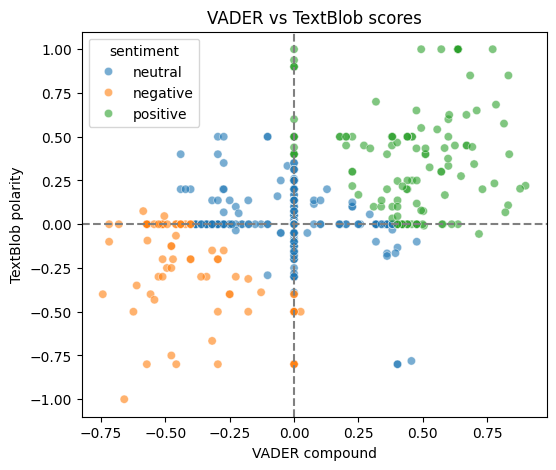

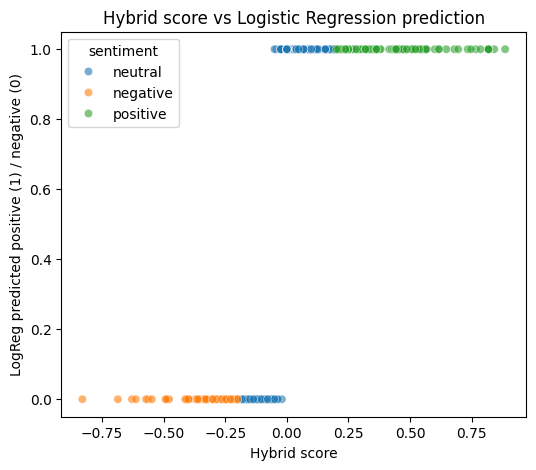

In [76]:
# VADER vs TextBlob
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="vader_score", y="tb_score",
    hue="sentiment", data=df, alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.axhline(0, color="gray", linestyle="--")
plt.title("VADER vs TextBlob scores")
plt.xlabel("VADER compound")
plt.ylabel("TextBlob polarity")
plt.show()

# Hybrid vs Logistic Regression decision (numeric encoding)
df["logreg_num"] = (df["logreg_pred"]=="positive").astype(int)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x="hybrid_score", y="logreg_num",
    hue="sentiment", data=df, alpha=0.6
)
plt.title("Hybrid score vs Logistic Regression prediction")
plt.xlabel("Hybrid score")
plt.ylabel("LogReg predicted positive (1) / negative (0)")
plt.show()

In [77]:
# Example: VADER strongly positive, TextBlob strongly negative, or vice versa
disagree = df[
    ((df["vader_score"] > 0.4) & (df["tb_score"] < -0.2)) |
    ((df["vader_score"] < -0.4) & (df["tb_score"] > 0.2))
].copy()

disagree_full = disagree[[
    "id","title","author","created_utc",
    "score","upvote_ratio","subreddit","country",
    "vader_score","tb_score","hybrid_score",
    "sentiment","logreg_pred","lstm_pred"
]]

display(disagree_full.head(30))
disagree_full.to_csv("sentiment_outliers_full_rows.csv", index=False)

,id,title,author,created_utc,score,upvote_ratio,subreddit,country,vader_score,tb_score,hybrid_score,sentiment,logreg_pred,lstm_pred
478,1ny0qqi,I am sorry I jumped Ship to Apple !! I wish I ...,aayush3299,2025-10-04T17:56:37,0,0.48,samsunggalaxy,United States,0.4559,-0.78125,-0.162675,neutral,negative,neutral
498,1nxptc9,Help me decide between s24 ultra and iphone 17...,Charming_Host2004,2025-10-04T09:50:10,1,1.00,PickAnAndroidForMe,United States,0.4019,-0.80000,-0.199050,neutral,negative,neutral
501,1nxp2rj,Help me decide between s24 ultra and iphone 17...,Charming_Host2004,2025-10-04T09:03:01,0,0.25,Smartphones,United States,0.4019,-0.80000,-0.199050,neutral,negative,neutral
786,1nzvbge,iPhone 15 Pro Max: to fix or not to fix? It ha...,throwaway10327591,2025-10-06T21:02:00,2,0.76,iphone,United States,-0.4404,0.40000,-0.020200,neutral,negative,neutral


In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Logistic Regression metrics (binary positive vs negative)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression classification report:\n")
print(classification_report(y_test, y_pred_log))

# Linear SVM metrics
y_pred_svm = svm.predict(X_test)
print("Linear SVM classification report:\n")
print(classification_report(y_test, y_pred_svm))

Logistic Regression classification report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

Linear SVM classification report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
    positive       1.00      1.00      1.00        29

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

